
# Capstone Project - Similarity between São Paulo and São José do Rio Preto

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

I currently work in São Paulo and I know and love every corner of this city, but recently I received a great job offer to work in another city, São José do Rio Preto, and now I'm moving to there.

I don't know anything about my new city and to facilitate my adaptation I would like to have a comparison between this two citys, so I can find regions similar to São Paulo in São José do Rio Preto, such as where the bars are, the historical and cultural places, the grastonomical points and etc.

So, in this project we will try to classify each district of the two cities and so identify the similar regions. In this way, will be possible to have an idea about a region of the new city based in a known region of the old city .

# Data <a name="data"></a>

The division unit chosen for classification was districts, below we have the images of the two cities broken into districts according to the official websites of their prefectures.

<img src="twoCities.jpg" width="800" />

I did an intensive search to find a dataset containing information about the districts and their coordinates, but without success. So I had to build my own dataset using google maps and adding coordinates manually. With this process, two CSV files were generated containing the districts and coordinates of each city. The files are in this repository and can be used for further analysis.

<img src="cordinates.png" width="400" />

The data of venues, like their type and location in every district can be obtained using Foursquare API.
So, for this project we will pass as parameter the locations for each district and then we will retreive all  categories of venues within a 1Km radius of that point.

## Visualizing Data <a name="data"></a>

In [1710]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import folium # map rendering library
import requests # library to handle requests
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [1711]:
#read the csv as dataframe
df_sp = pd.read_csv("datasets/SaoPaulo.csv")
df_rp = pd.read_csv("datasets/RioPreto.csv")

In [1712]:
#display data
df_sp.head()

,Zona,Distritos,Latitude,Longitude
0,Central,Barra Funda,-23.527390,-46.659511
1,Central,Bela Vista,-23.559208,-46.644889
2,Central,Bom Retiro,-23.523983,-46.639989
3,Central,Brás,-23.542579,-46.615690
4,Central,Consolação,-23.553108,-46.655249


### let's visualize districs in São Paulo

In [1713]:
# create map of São Paulo using latitude and longitude values
latitudeSP =-23.5499
longitudeSP =-46.5799

map_sp = folium.Map(location=[latitudeSP, longitudeSP], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_sp['Latitude'], df_sp['Longitude'], df_sp['Distritos']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

### let's visualize districs in São José do RIo Preto

In [1714]:
# create map of São José do Rio Preto using latitude and longitude values
latitudeRP =-20.8202
longitudeRP =-49.3797

map_rp = folium.Map(location=[latitudeRP, longitudeRP], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_rp['Latitude'], df_rp['Longitude'], df_rp['Distritos']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rp)  
    
map_rp

Let's merge the two dataset in one and create a new column to city

In [1715]:
df_sp['City']='São Paulo'
df_rp['City']='São José do Rio Preto'

df_twoCities = df_sp.append(df_rp)
df_twoCities.head()

,Zona,Distritos,Latitude,Longitude,City
0,Central,Barra Funda,-23.527390,-46.659511,São Paulo
1,Central,Bela Vista,-23.559208,-46.644889,São Paulo
2,Central,Bom Retiro,-23.523983,-46.639989,São Paulo
3,Central,Brás,-23.542579,-46.615690,São Paulo
4,Central,Consolação,-23.553108,-46.655249,São Paulo


In [1716]:
#confirm the shape of dataframe
print(df_sp.shape)
print(df_rp.shape)
print(df_twoCities.shape)

(96, 5)
(34, 5)
(130, 5)


# Methodology <a name="introduction"></a>

## Explore Districts in boyh cities

#### Define Foursquare Credentials and Version

In [1717]:
#CLIENT_ID = 'HYBGCJIEEJYDPSOQ1UNKBENBMQE00U2LOP5GRLWEFM3ENHOF' # your Foursquare ID
#CLIENT_SECRET = 'HVLZGDSNOLBNMVPVVM42UXXV4L1W42KBRX3KWHRGZFGAIRJC' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version

In [1718]:
CLIENT_ID = 'GZNFHFKLKTRBES00QE2JEMPLE0E3LSVJAQL23Y51UMD1RQEU' # your Foursquare ID
CLIENT_SECRET = 'VTF314V2ARYQL50BD4VEV4SQENS1ONROW3NTQFPMMNW3JBCC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Function to get the top 100 venues that are in each District within a radius of 900 meters.

In [2018]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 900 # define radius

def getNearbyVenues(city,district, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for city,district, lat, lng in zip(city,district, latitudes, longitudes):
        #print("city:",city," district:",district)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            district,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'District',
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each district and create a new dataframe called *cities_venues*.

In [ ]:
cities_venues = getNearbyVenues(city=df_twoCities['City'],
                                   district=df_twoCities['Distritos'],
                                   latitudes=df_twoCities['Latitude'],
                                   longitudes=df_twoCities['Longitude']
                                  )



#### Let's check the size of the resulting dataframe

In [1721]:
print(cities_venues.shape)
cities_venues.head()

(6750, 8)


,City,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,São Paulo,Barra Funda,-23.52739,-46.659511,D-Edge,-23.528040,-46.662069,Nightclub
1,São Paulo,Barra Funda,-23.52739,-46.659511,Terraço D-Edge,-23.528139,-46.662137,Lounge
2,São Paulo,Barra Funda,-23.52739,-46.659511,Rock Dogg's,-23.529724,-46.658273,Food Truck
3,São Paulo,Barra Funda,-23.52739,-46.659511,Estúdio Paraná Pompéia,-23.528975,-46.659227,Music Venue
4,São Paulo,Barra Funda,-23.52739,-46.659511,"Bacalhau, Vinho e Cia",-23.526618,-46.659990,Portuguese Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues

In [1722]:
print('There are {} uniques categories.'.format(len(cities_venues['Venue Category'].unique())))

There are 377 uniques categories.


In [1723]:
sp_count =cities_venues.loc[cities_venues['City'] == 'São Paulo'].groupby('District').count()[['Venue']]

In [1724]:
sp_count = sp_count.sort_values(by=['Venue'])

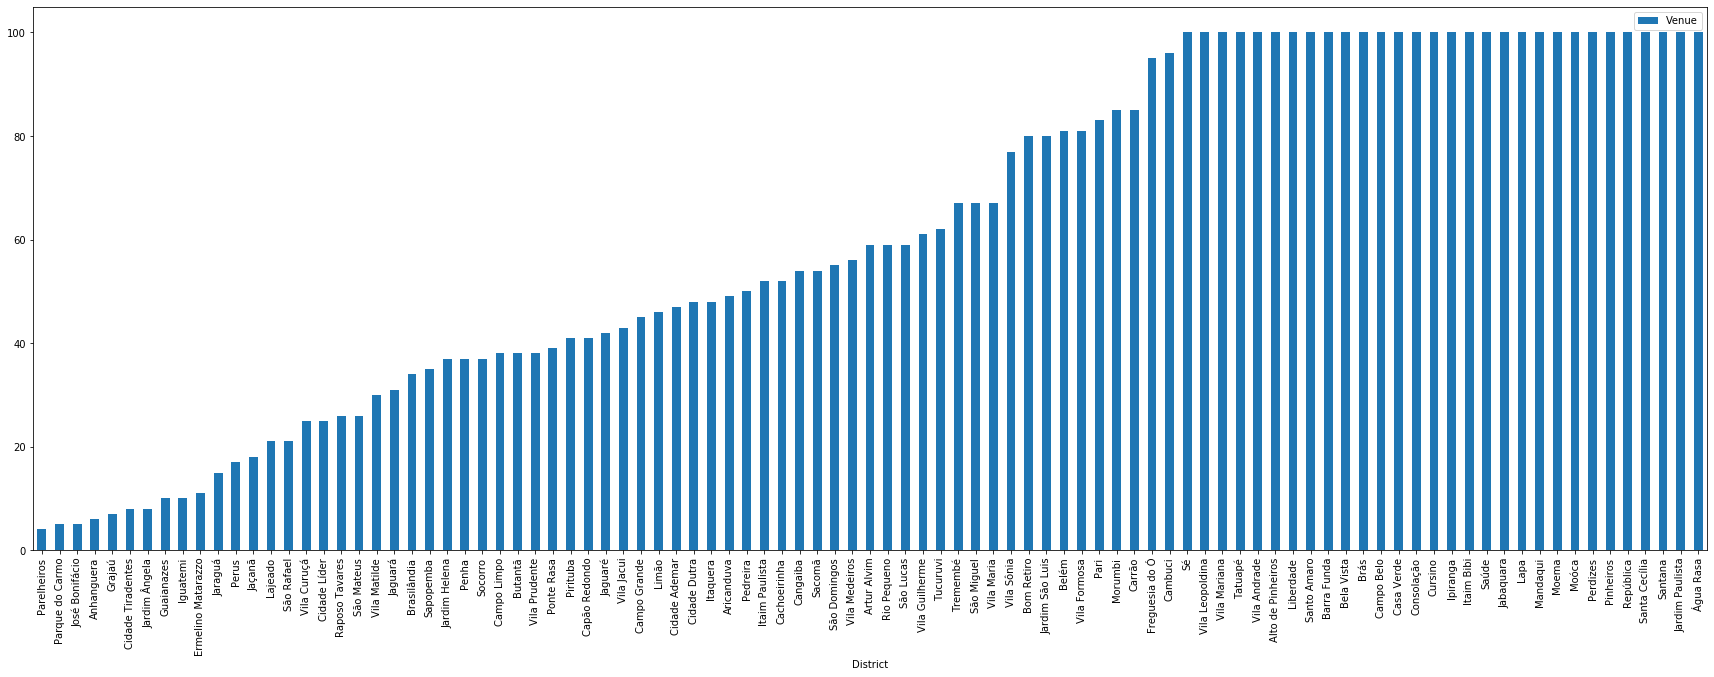

In [1725]:
sp_count.plot(kind='bar', figsize=(30, 10))

In [1726]:
rp_count =cities_venues.loc[cities_venues['City'] == 'São José do Rio Preto'].groupby('District').count()[['Venue']]
rp_count = rp_count.sort_values(by=['Venue'])

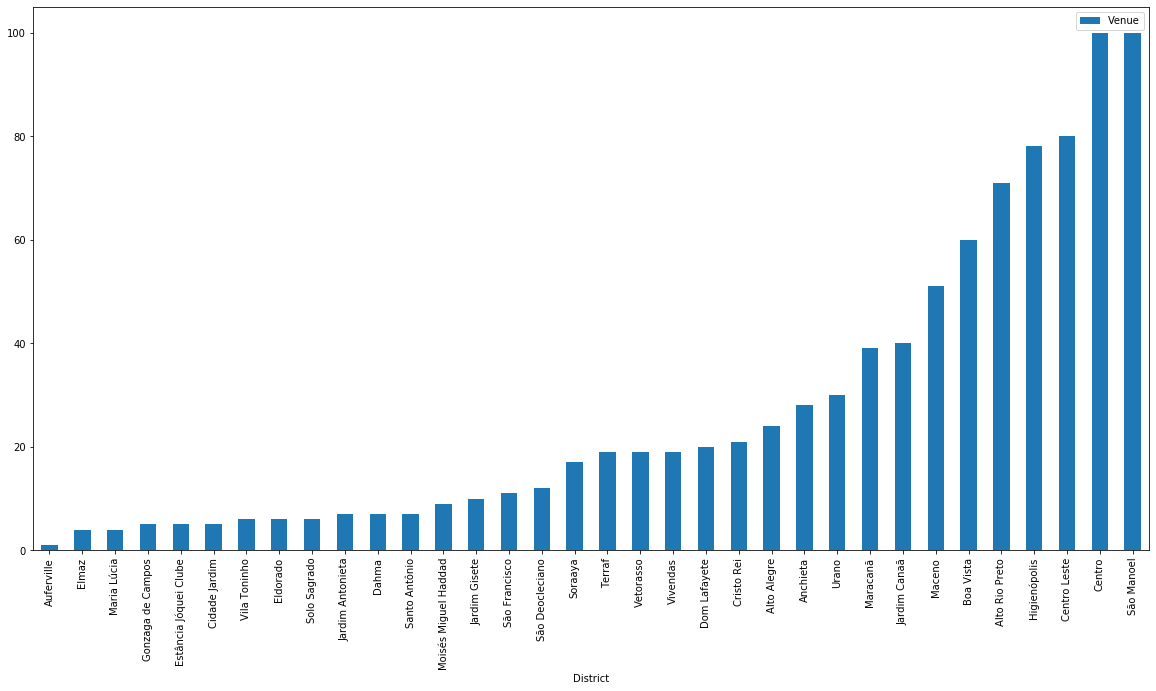

In [1727]:
rp_count.plot(kind='bar', figsize=(20, 10))

In [2535]:
sp_his = sp_count.Venue.tolist()
rp_his = rp_count.Venue.tolist()

Text(0, 0.5, 'Frequency')

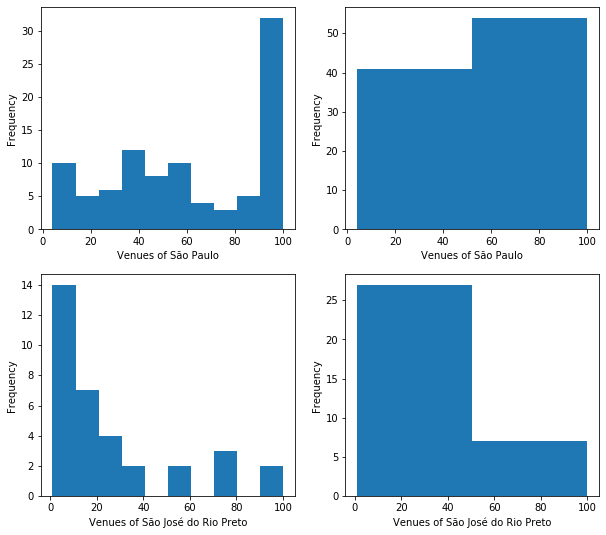

In [2551]:
fig = plt.figure(figsize=(10,9))

ax1 = fig.add_subplot(2, 2, 1)

ax1.hist(sp_his, bins = 10)
ax1.set_xlabel('Venues of São Paulo')
ax1.set_ylabel('Frequency')
#plt.title('oi')

ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(sp_his, bins = 2)
ax2.set_xlabel('Venues of São Paulo')
ax2.set_ylabel('Frequency')
#plt.title('oi')
#ax2.set_ylabel('Frequency')

ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(rp_his, bins = 10)
ax3.set_xlabel('Venues of São José do Rio Preto')
ax3.set_ylabel('Frequency')

ax4 = fig.add_subplot(2, 2, 4)
ax4.hist(rp_his, bins = 2)
ax4.set_xlabel('Venues of São José do Rio Preto')
ax4.set_ylabel('Frequency')

####  lets explore the differents venus

In [1728]:
cities_venues_count =cities_venues.groupby('District').count()[['Venue']]

In [2636]:
filter1 = cities_venues_count.loc[cities_venues_count['Venue']>59]

In [2637]:
valids = cities_venues.District.isin(filter1.index)

In [2638]:
cities_venues2 = cities_venues[valids]

In [2639]:
cities_venues2.shape

(4656, 8)

In [2687]:
sp_uniq = cities_venues2.loc[cities_venues2['City'] == 'São Paulo']['Venue Category'].unique()
rp_uniq = cities_venues2.loc[cities_venues2['City'] == 'São José do Rio Preto']['Venue Category'].unique()

In [2684]:
def convert(input_list):
    all_nums = set()
    for inner_list in input_list:
        all_nums.add(inner_list)
    return all_nums

In [2688]:
sp_set = convert(sp_uniq)
rp_set = convert(rp_uniq)
inter = sp_set.intersection(rp_set)

In [2689]:
print('There are {} uniques categories.'.format(len(cities_venues2['Venue Category'].unique())))
print('There are {} uniques categories in São Paulo.'.format(len(sp_uniq)))
print('There are {} uniques categories in São Paulo.'.format(len(rp_uniq)))
print('There are {} uniques categories in common.'.format(len(inter)))

There are 341 uniques categories.
There are 332 uniques categories in São Paulo.
There are 120 uniques categories in São Paulo.
There are 111 uniques categories in common.


#### To cluster the neighborhood we need to transform tha data in numerical values

In [2640]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues2[['Venue Category']], prefix="", prefix_sep="")

In [2641]:
# add district column back to dataframe
cities_onehot['City'] = cities_venues2['City']
cities_onehot['District'] = cities_venues2['District']
cities_onehot.head()

,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Borek Place,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Gym,College Library,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Shop,Dive Spot,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empada House,Empanada Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Lighting Store,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mental Health Office,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Piercing Parlor,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Samba School,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer S

In [2642]:
# move CIty and District columns to the first and second columns
fixed_columns = [cities_onehot.columns[-2]] + [cities_onehot.columns[-1]]+list(cities_onehot.columns[:-2])
cities_onehot = cities_onehot[fixed_columns]
cities_onehot.head()

,City,District,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Borek Place,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Gym,College Library,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Shop,Dive Spot,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empada House,Empanada Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Lighting Store,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mental Health Office,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Piercing Parlor,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Samba School,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer 

let's examine the new dataframe size

In [2643]:
cities_onehot.shape

(4656, 343)

#### Now, let's group rows by City and District and by taking the mean of the frequency of occurrence of each category

In [2644]:
cities_grouped = cities_onehot.groupby(['City','District']).mean().reset_index()
#cities_onehot[teste]

In [2645]:
cities_grouped.head()

,City,District,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Borek Place,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Gym,College Library,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Shop,Dive Spot,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empada House,Empanada Restaurant,Event Service,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Lighting Store,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mental Health Office,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Piercing Parlor,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Salsa Club,Samba School,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer 

In [2646]:
cities_grouped.shape

(51, 343)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order

In [3416]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [3417]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['City'] = cities_grouped['City']
districts_venues_sorted['District'] = cities_grouped['District']

for ind in np.arange(cities_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 2:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head()

,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,São José do Rio Preto,Alto Rio Preto,Brazilian Restaurant,Bar,Restaurant,Hotel,Airport Terminal,Bakery,BBQ Joint
1,São José do Rio Preto,Boa Vista,Ice Cream Shop,Bakery,Bar,Food Truck,Brazilian Restaurant,Grocery Store,Coffee Shop
2,São José do Rio Preto,Centro,Japanese Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Ice Cream Shop,Pastelaria,French Restaurant
3,São José do Rio Preto,Centro Leste,Japanese Restaurant,Bar,Restaurant,Dive Bar,Pastelaria,Ice Cream Shop,Gym
4,São José do Rio Preto,Higienópolis,Brazilian Restaurant,Pizza Place,Japanese Restaurant,Electronics Store,Bar,Dessert Shop,Plaza


In [3418]:
districts_venues_sorted.shape

(51, 9)

## Choose the best k

In [3419]:
districts_grouped_clustering = cities_grouped.drop(['City','District'], 1)

In [3420]:
k_rng = range(2,30)
sse = []
sil=[]
for k in k_rng:
    km = KMeans(n_clusters=k,random_state=0)
    km.fit(districts_grouped_clustering)
    labels = km.labels_
    sse.append(km.inertia_)
    sil.append(silhouette_score(districts_grouped_clustering,labels))

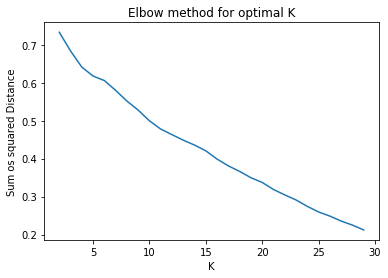

In [3421]:
plt.xlabel('K')
plt.ylabel('Sum os squared Distance')
plt.title('Elbow method for optimal K')
plt.plot(k_rng, sse)

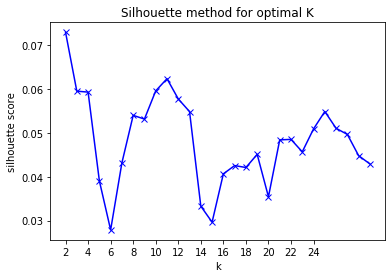

In [3422]:
plt.plot(k_sil, sil, 'bx-')
plt.xlabel('k')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24])
plt.ylabel('silhouette score')
plt.title('Silhouette method for optimal K')
plt.show()

#### silhouette plot

Para n_clusters = 8 O score_silhouette médio é : 0.054017688836616916


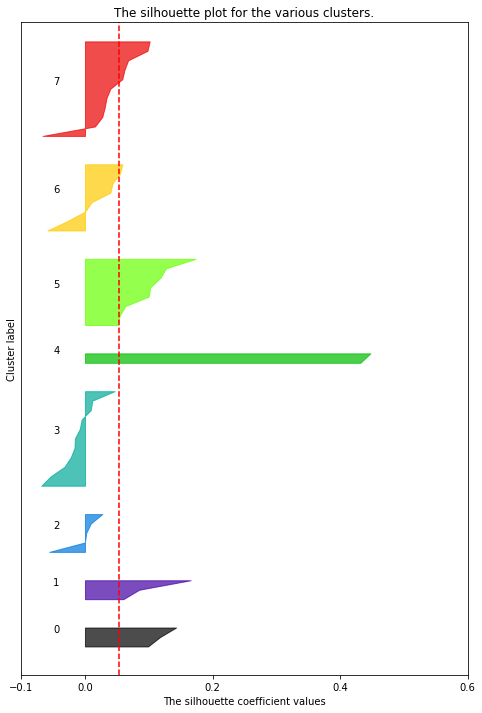

In [3423]:
range_n_clusters = [8]
for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots()
    fig.set_size_inches(8, 12)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-1, 1]
    ax1.set_xlim([-0.1, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(districts_grouped_clustering) + (n_clusters +1 ) * 2])
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    clusterer.fit(districts_grouped_clustering)
    cluster_labels = clusterer.labels_
    #cluster_labels = clusterer.fit_predict(districts_grouped_clustering)
    silhouette_avg = silhouette_score(districts_grouped_clustering, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(districts_grouped_clustering, cluster_labels,metric='euclidean')
    y_lower = 3
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 2  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])

plt.show()

#### Now lets Run *k*-means to cluster the neighborhood into 8 clusters

In [3424]:
# set number of clusters
kclusters = 8

districts_grouped_clustering = cities_grouped.drop(['City','District'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(districts_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 7, 3, 3, 3, 6, 2, 3, 6, 5], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [3425]:
# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
districts_venues_sorted.head()

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,7,São José do Rio Preto,Alto Rio Preto,Brazilian Restaurant,Bar,Restaurant,Hotel,Airport Terminal,Bakery,BBQ Joint
1,7,São José do Rio Preto,Boa Vista,Ice Cream Shop,Bakery,Bar,Food Truck,Brazilian Restaurant,Grocery Store,Coffee Shop
2,3,São José do Rio Preto,Centro,Japanese Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Ice Cream Shop,Pastelaria,French Restaurant
3,3,São José do Rio Preto,Centro Leste,Japanese Restaurant,Bar,Restaurant,Dive Bar,Pastelaria,Ice Cream Shop,Gym
4,3,São José do Rio Preto,Higienópolis,Brazilian Restaurant,Pizza Place,Japanese Restaurant,Electronics Store,Bar,Dessert Shop,Plaza


In [3426]:
districts_venues_sorted

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,7,São José do Rio Preto,Alto Rio Preto,Brazilian Restaurant,Bar,Restaurant,Hotel,Airport Terminal,Bakery,BBQ Joint
1,7,São José do Rio Preto,Boa Vista,Ice Cream Shop,Bakery,Bar,Food Truck,Brazilian Restaurant,Grocery Store,Coffee Shop
2,3,São José do Rio Preto,Centro,Japanese Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Ice Cream Shop,Pastelaria,French Restaurant
3,3,São José do Rio Preto,Centro Leste,Japanese Restaurant,Bar,Restaurant,Dive Bar,Pastelaria,Ice Cream Shop,Gym
4,3,São José do Rio Preto,Higienópolis,Brazilian Restaurant,Pizza Place,Japanese Restaurant,Electronics Store,Bar,Dessert Shop,Plaza
5,6,São José do Rio Preto,São Manoel,Hotel,Café,Ice Cream Shop,Brazilian Restaurant,Restaurant,Pharmacy,Burger Joint
6,2,São Paulo,Alto de Pinheiros,Plaza,Clothing Store,Athletics & Sports,Bike Rental / Bike Share,Cosmetics Shop,Convenience Store,Café
7,3,São Paulo,Barra Funda,Pizza Place,Nightclub,Brazilian Restaurant,Restaurant,Bakery,Café,Beer Bar
8,6,São Paulo,Bela Vista,Italian Restaurant,Theater,Hotel,Japanese Restaurant,Pizza Place,Bakery,Bar
9,5,São Paulo,Belém,Bakery,Brazilian Restaurant,Ice Cream Shop,Furniture / Home Store,Japanese Restaurant,Restaurant,Café


In [3429]:
#merge toronto_grouped with cities_data to add latitude/longitude for each district
districts_merged = df_twoCities
new_districts_venues_sorted = districts_venues_sorted.drop('City',1)
districts_merged = districts_merged.join(new_districts_venues_sorted.set_index('District'), on='Distritos', how = 'right')
districts_merged.head() # check the last columns!

,Zona,Distritos,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Central,Barra Funda,-23.527390,-46.659511,São Paulo,3,Pizza Place,Nightclub,Brazilian Restaurant,Restaurant,Bakery,Café,Beer Bar
1,Central,Bela Vista,-23.559208,-46.644889,São Paulo,6,Italian Restaurant,Theater,Hotel,Japanese Restaurant,Pizza Place,Bakery,Bar
2,Central,Bom Retiro,-23.523983,-46.639989,São Paulo,3,Brazilian Restaurant,Korean Restaurant,Dessert Shop,Women's Store,Café,Restaurant,Sandwich Place
3,Central,Brás,-23.542579,-46.615690,São Paulo,2,Brazilian Restaurant,Clothing Store,Café,Furniture / Home Store,Pizza Place,Restaurant,Italian Restaurant
4,Central,Consolação,-23.553108,-46.655249,São Paulo,6,Hotel,Coffee Shop,Bakery,Ice Cream Shop,Brazilian Restaurant,French Restaurant,Bar


#### let's visualize the data 

In [3430]:
# create map
map_clusters = folium.Map(location=[latitudeSP, longitudeSP], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(districts_merged['Latitude'], districts_merged['Longitude'], districts_merged['Distritos'], districts_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

AttributeError: 'numpy.ndarray' object has no attribute 'rgb2hex'

## 5. Examine Clusters

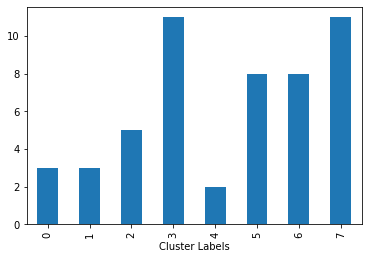

In [3452]:
freq = districts_venues_sorted.groupby('Cluster Labels').count()['District']
cluster_freq = pd.DataFrame(freq)
cluster_freq.plot(kind='bar',legend=False)

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [3439]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 0]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
22,0,São Paulo,Jardim Paulista,Italian Restaurant,Brazilian Restaurant,Dessert Shop,Athletics & Sports,Middle Eastern Restaurant,Bakery,Restaurant
33,0,São Paulo,República,Bar,Brazilian Restaurant,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Peruvian Restaurant,Pizza Place
43,0,São Paulo,Vila Andrade,Italian Restaurant,Brazilian Restaurant,Dessert Shop,Coffee Shop,Mineiro Restaurant,Gym / Fitness Center,Burger Joint


#### Cluster 2

In [3440]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 1]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
42,1,São Paulo,Tucuruvi,Bakery,Pizza Place,Burger Joint,Farmers Market,Pharmacy,Dessert Shop,Pet Store
44,1,São Paulo,Vila Formosa,Bakery,Plaza,Pizza Place,Gym / Fitness Center,Dessert Shop,Burger Joint,Farmers Market
49,1,São Paulo,Vila Sônia,Bakery,Pizza Place,Grocery Store,Farmers Market,Japanese Restaurant,Ice Cream Shop,Bar


#### Cluster 3

In [3441]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 2]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
6,2,São Paulo,Alto de Pinheiros,Plaza,Clothing Store,Athletics & Sports,Bike Rental / Bike Share,Cosmetics Shop,Convenience Store,Café
11,2,São Paulo,Brás,Brazilian Restaurant,Clothing Store,Café,Furniture / Home Store,Pizza Place,Restaurant,Italian Restaurant
28,2,São Paulo,Morumbi,Restaurant,Pizza Place,Soccer Stadium,Café,Gym / Fitness Center,Pet Store,Gym
30,2,São Paulo,Pari,Brazilian Restaurant,Restaurant,Clothing Store,Middle Eastern Restaurant,Churrascaria,Café,Gift Shop
36,2,São Paulo,Santo Amaro,Clothing Store,Pizza Place,Gym / Fitness Center,Bar,Restaurant,Gym,Department Store


#### Cluster 4

In [3442]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 3]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
2,3,São José do Rio Preto,Centro,Japanese Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,Ice Cream Shop,Pastelaria,French Restaurant
3,3,São José do Rio Preto,Centro Leste,Japanese Restaurant,Bar,Restaurant,Dive Bar,Pastelaria,Ice Cream Shop,Gym
4,3,São José do Rio Preto,Higienópolis,Brazilian Restaurant,Pizza Place,Japanese Restaurant,Electronics Store,Bar,Dessert Shop,Plaza
7,3,São Paulo,Barra Funda,Pizza Place,Nightclub,Brazilian Restaurant,Restaurant,Bakery,Café,Beer Bar
10,3,São Paulo,Bom Retiro,Brazilian Restaurant,Korean Restaurant,Dessert Shop,Women's Store,Café,Restaurant,Sandwich Place
13,3,São Paulo,Campo Belo,Bar,Dessert Shop,Spa,Brazilian Restaurant,Gym / Fitness Center,Bakery,Middle Eastern Restaurant
34,3,São Paulo,Santa Cecília,Pizza Place,Italian Restaurant,Middle Eastern Restaurant,Brazilian Restaurant,Dessert Shop,Plaza,Restaurant
35,3,São Paulo,Santana,Pizza Place,Burger Joint,Japanese Restaurant,Dessert Shop,Bar,Pharmacy,Restaurant
37,3,São Paulo,Saúde,Pizza Place,Japanese Restaurant,Dessert Shop,Gym / Fitness Center,Gym,Gymnastics Gym,Cosmetics Shop
40,3,São Paulo,Tatuapé,Restaurant,Ice Cream Shop,Coffee Shop,Dessert Shop,Pizza Place,Cosmetics Shop,Gym / Fitness Center


#### Cluster 5

In [3443]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 4]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
25,4,São Paulo,Liberdade,Japanese Restaurant,Theater,Sake Bar,Bakery,Grocery Store,Bookstore,Cosmetics Shop
39,4,São Paulo,Sé,Japanese Restaurant,Sake Bar,Bakery,Cosmetics Shop,Cultural Center,Brazilian Restaurant,Theater


#### Cluster 6

In [3444]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 5]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
9,5,São Paulo,Belém,Bakery,Brazilian Restaurant,Ice Cream Shop,Furniture / Home Store,Japanese Restaurant,Restaurant,Café
12,5,São Paulo,Cambuci,Brazilian Restaurant,Bakery,Restaurant,Pharmacy,Pizza Place,Dessert Shop,Farmers Market
19,5,São Paulo,Ipiranga,Brazilian Restaurant,Bar,Burger Joint,Pizza Place,Snack Place,Skate Park,Gym
21,5,São Paulo,Jabaquara,Brazilian Restaurant,Café,Tea Room,Gym / Fitness Center,Pet Store,Bar,Argentinian Restaurant
23,5,São Paulo,Jardim São Luis,Brazilian Restaurant,Bakery,Gym / Fitness Center,Café,Pizza Place,Pharmacy,Buffet
24,5,São Paulo,Lapa,Brazilian Restaurant,Pharmacy,Restaurant,Pastelaria,Bakery,Japanese Restaurant,Pizza Place
38,5,São Paulo,São Miguel,Bakery,Gym,Brazilian Restaurant,Pizza Place,Chocolate Shop,Japanese Restaurant,Restaurant
45,5,São Paulo,Vila Guilherme,Brazilian Restaurant,Pharmacy,Restaurant,Bakery,Pet Store,Burger Joint,Middle Eastern Restaurant


#### Cluster 7

In [3445]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 6]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
5,6,São José do Rio Preto,São Manoel,Hotel,Café,Ice Cream Shop,Brazilian Restaurant,Restaurant,Pharmacy,Burger Joint
8,6,São Paulo,Bela Vista,Italian Restaurant,Theater,Hotel,Japanese Restaurant,Pizza Place,Bakery,Bar
16,6,São Paulo,Consolação,Hotel,Coffee Shop,Bakery,Ice Cream Shop,Brazilian Restaurant,French Restaurant,Bar
20,6,São Paulo,Itaim Bibi,Japanese Restaurant,Italian Restaurant,Hotel,Coffee Shop,Restaurant,Bar,Steakhouse
27,6,São Paulo,Moema,Ice Cream Shop,Spa,Burger Joint,Bar,Supermarket,Health & Beauty Service,Cosmetics Shop
31,6,São Paulo,Perdizes,Dessert Shop,Burger Joint,Pizza Place,Pharmacy,Bar,Vegetarian / Vegan Restaurant,Italian Restaurant
32,6,São Paulo,Pinheiros,Bar,Pet Store,Italian Restaurant,Art Gallery,Burger Joint,Coffee Shop,Bookstore
48,6,São Paulo,Vila Mariana,Hostel,Dessert Shop,Burger Joint,Ice Cream Shop,Italian Restaurant,Café,Brazilian Restaurant


#### Cluster 7

In [3446]:
districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == 7]

,Cluster Labels,City,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,7,São José do Rio Preto,Alto Rio Preto,Brazilian Restaurant,Bar,Restaurant,Hotel,Airport Terminal,Bakery,BBQ Joint
1,7,São José do Rio Preto,Boa Vista,Ice Cream Shop,Bakery,Bar,Food Truck,Brazilian Restaurant,Grocery Store,Coffee Shop
14,7,São Paulo,Carrão,Japanese Restaurant,Pizza Place,Pharmacy,Bar,Bakery,BBQ Joint,Grocery Store
15,7,São Paulo,Casa Verde,Restaurant,Bar,Gym / Fitness Center,Music Venue,Gym,Bakery,Burger Joint
17,7,São Paulo,Cursino,Bakery,Burger Joint,Gym / Fitness Center,Gym,Farmers Market,Fruit & Vegetable Store,Pet Store
18,7,São Paulo,Freguesia do Ó,Pizza Place,Plaza,Brazilian Restaurant,Gym / Fitness Center,Bar,Pharmacy,Italian Restaurant
26,7,São Paulo,Mandaqui,Gym,Bar,Pizza Place,Brazilian Restaurant,Burger Joint,Bakery,Pharmacy
29,7,São Paulo,Moóca,Bar,Pizza Place,Gym / Fitness Center,Bakery,Dessert Shop,Café,Mexican Restaurant
41,7,São Paulo,Tremembé,Pizza Place,Restaurant,Bakery,Bar,Fast Food Restaurant,Burger Joint,Gym
47,7,São Paulo,Vila Maria,Bar,Pharmacy,Restaurant,Pizza Place,Bakery,Chocolate Shop,Japanese Restaurant


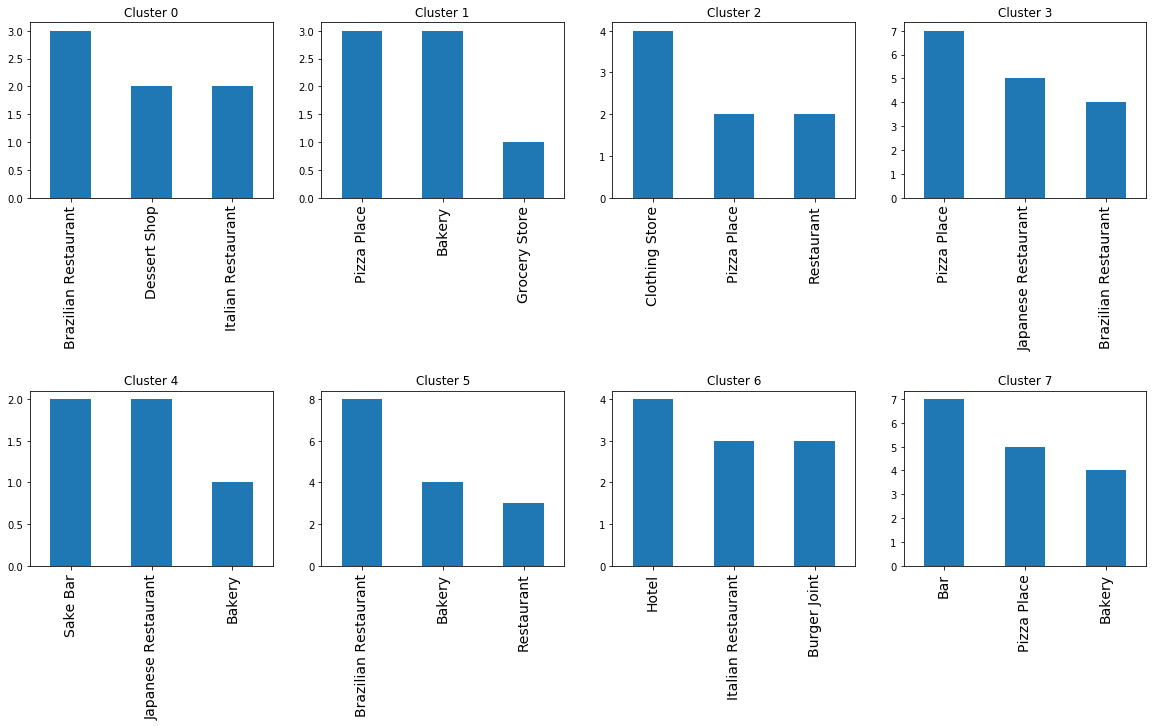

In [3448]:
figures = plt.figure(figsize=(20,10))
for i in range(0,8):
    one= districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == i]['1st Most Common Venue'].rename('venues')
    two= districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == i]['2nd Most Common Venue'].rename('venues')
    three= districts_venues_sorted.loc[districts_venues_sorted['Cluster Labels'] == i]['3rd Most Common Venue'].rename('venues')
    one = pd.DataFrame(one)
    two = pd.DataFrame(two)
    three = pd.DataFrame(three)
    frames = [one, two, three]
    result = pd.concat(frames, ignore_index=True)
    final =result['venues'].value_counts()[:3]
    final_df = pd.DataFrame(final)
    ax1 = figures.add_subplot(2, 4, i+1)
    ax1.set_title('Cluster '+str(i))
    ax1.tick_params(axis="x", labelsize=14)
    final_df.plot(kind='bar',ax=ax1,legend=False)
figures.subplots_adjust(hspace=1.1)

In [3449]:
data = [[0,'Brazilian Restaurant'],[1,'Pizza Place/Bakery'],[2,'Clothing Store'],[3,'Pizza Place'],
        [4,'Sake Bar/Japanese Restaurant'],[5,'Brazilian Restaurants2'],[6,'Hotels'],[7,'Bar']]
df = pd.DataFrame(data,columns=['Cluster','Name']).set_index('Cluster')
df

,Name
Cluster,
0,Brazilian Restaurant
1,Pizza Place/Bakery
2,Clothing Store
3,Pizza Place
4,Sake Bar/Japanese Restaurant
5,Brazilian Restaurants2
6,Hotels
7,Bar
